# Setup

In [1]:
# Import python packages
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import math
from datetime import datetime as dt

# # Cartopy imports
import cartopy.crs as ccrs
# import cartopy.feature as cfeature
from cartopy import util as cutil
# import cartopy.mpl.ticker as cticker 

from matplotlib import animation
from matplotlib.widgets import Button, Slider
import warnings
plt.close('all')
%matplotlib module://matplotlib_inline.backend_inline

In [2]:
# Loading in dataset: (duplicate cell for multiple datasets, and change variable name)

path = 'H:\\Summer24-25\\' # enter file path here ---> double slashes or change direction eg. \ --> \\ or / 
name = '*_Amon_CESM2-WACCM_ssp126*.nc' # enter file name here --> use * if need multiple files/versions per dataset
with warnings.catch_warnings():
    warnings.simplefilter('ignore') # some datasets have empty values, this ignores that warning--> if gives error, remove this to check
    ds = xr.open_mfdataset(path+name, parallel=True)

# this bit is to change the units of 'plev' (pressure level Pa -> hPa)
if ds.plev.attrs['units'] == 'Pa':
    ds['plev'] = ds.plev / 100
    ds.plev.attrs['axis'] = 'Z' # attributes get reset so have to redo them
    ds.plev.attrs['positive'] = 'down'
    ds.plev.attrs['standard_name'] = 'air_pressure'
    ds.plev.attrs['title'] = 'pressure'
    ds.plev.attrs['type'] = 'double'
    ds.plev.attrs['units'] = 'hPa'

ds.plev

<xarray.DataArray 'plev' (plev: 19)> Size: 152B
array([1000.,  925.,  850.,  700.,  600.,  500.,  400.,  300.,  250.,  200.,
        150.,  100.,   70.,   50.,   30.,   20.,   10.,    5.,    1.])
Coordinates:
  * plev     (plev) float64 152B 1e+03 925.0 850.0 700.0 ... 20.0 10.0 5.0 1.0
Attributes:
    axis:           Z
    positive:       down
    standard_name:  air_pressure
    title:          pressure
    type:           double
    units:          hPa

# Selecting data:

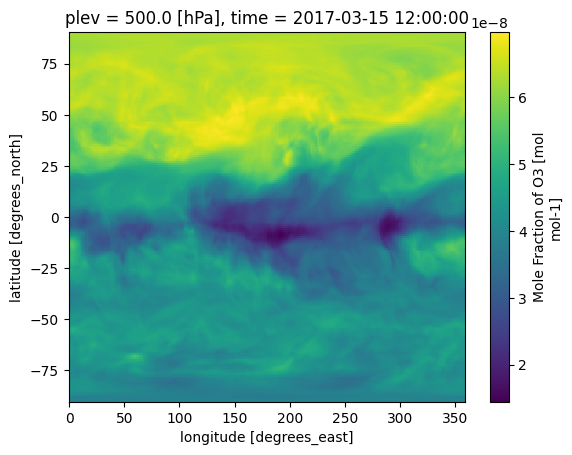

In [5]:
# by value:
ds.o3.sel(time='2017-03-15', plev=500).plot()

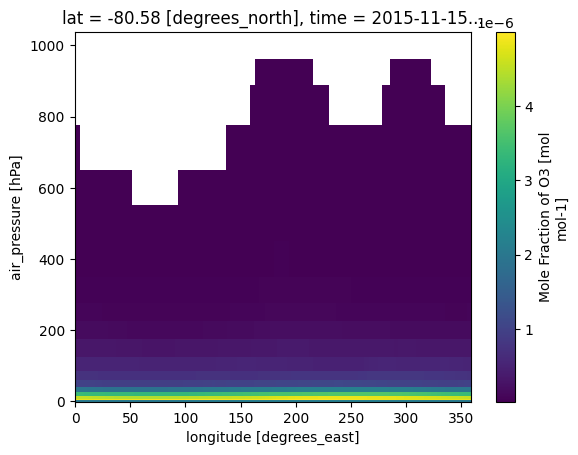

In [6]:
# by index:
ds.o3.isel(time=10, lat=10).plot()

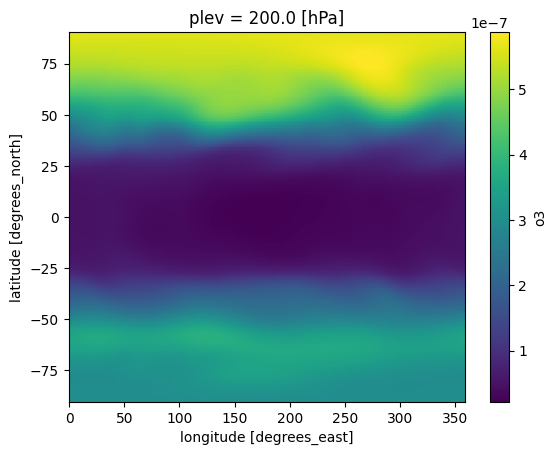

In [7]:
# take average of:
ds.o3.isel(plev=9).mean(dim='time').plot()

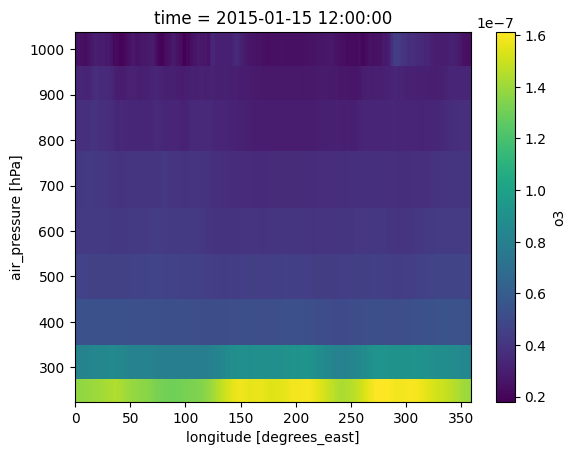

In [8]:
# slicing (selecting a range):
ds.o3.mean(dim='lat').isel(time=0,plev=slice(0,9)).plot()

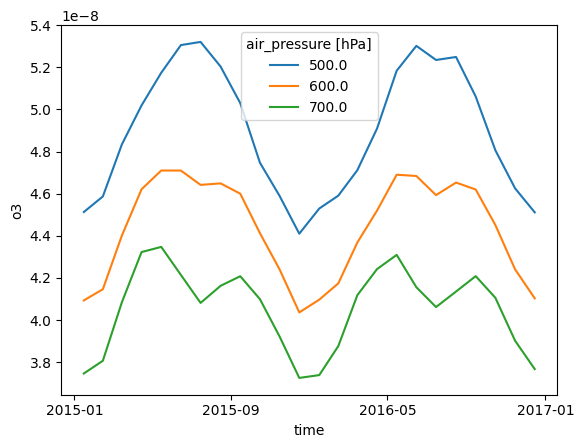

In [9]:
# selecting multiple values
ds.o3.mean(dim='lon').mean(dim='lat').isel(time=slice(0,24), plev=[5,4,3]).plot(hue='plev')

In [10]:
# getting attributes:
ds.o3.time.attrs

{'axis': 'T',
 'bounds': 'time_bnds',
 'standard_name': 'time',
 'title': 'time',
 'type': 'double'}

In [11]:
# converting to string:
print(str(ds.time[6].values))
print(str(ds.plev[3].values)+' hPa')

2015-07-15 12:00:00
700.0 hPa


# Annotation and Customisation

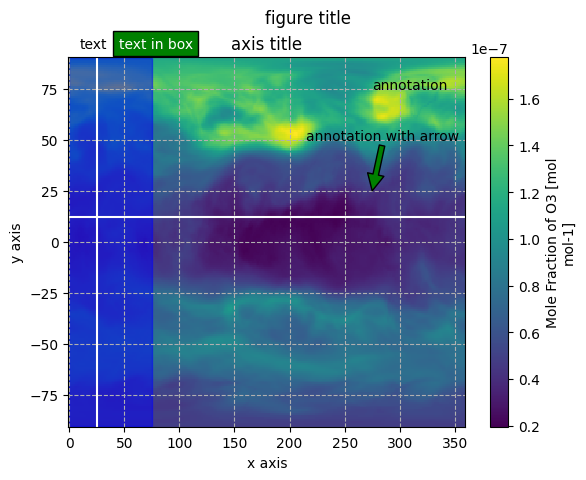

In [129]:
fig = plt.figure()
ax = plt.axes()
graph = data.plot(ax=ax)

# adding text: (coordinates are based on grid coords)
fig.suptitle('figure title')
ax.set(title='axis title', xlabel='x axis', ylabel='y axis')
plt.text(x=10,y=95, s='text')
plt.text(x=45, y=95, s='text in box', color='w', bbox=dict(fc='g'))
ax.annotate(xy=(275,75), text='annotation')
ax.annotate(xy=(275,25), xytext=(215,50), text='annotation with arrow',arrowprops=dict(fc='g'))
# for all text/titles, can change colour, font, style, size and more

#lines:
ax.axhline(y=12, c='w') #horizontal line
ax.axvline(x=25, c='w') #vertical line
ax.grid(True, ls='--')

#other:
rectangle = plt.Rectangle(xy=(0,-90), width=75, height=180, alpha=0.5, color='b')
ax.add_patch(rectangle)
rectangle.set_url('https://www.google.com/') # --> can be a web link or file address in same folder/directory

fig.savefig('annotate.svg') #links in images only work in svg format

# Plots

In [4]:
# default values: **Load this before any following plots **
timeindex = 0
pressurevalue = 200
default_data = ds.isel(time=timeindex).sel(plev=pressurevalue)

ozone = default_data.o3
eastwind = default_data.ua
northwind = default_data.va

fig_dimensions = (14,9)
projection = ccrs.EqualEarth()
transform = ccrs.PlateCarree()
cmap = 'turbo'
cnorm_o3 = mpl.colors.Normalize(vmin=4*10**-8, vmax=5*10**-7)
cnorm_wind = mpl.colors.Normalize(vmin=0, vmax=65)


def timefmt(timeindex, format='%Y %B'):
    date = dt.strptime(str(ds.time[timeindex].values), '%Y-%m-%d %H:%M:%S')
    return date.strftime(format)

## Basic

CPU times: total: 4.53 s
Wall time: 4.8 s


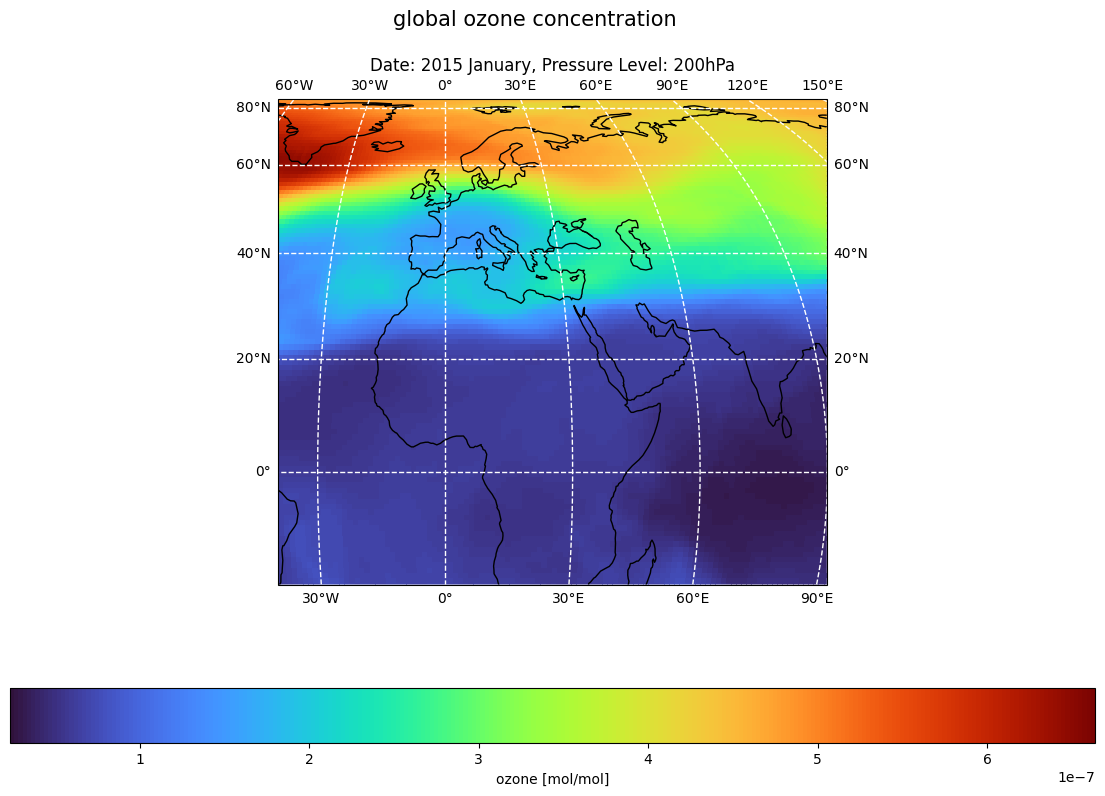

In [5]:
%%time
# location based scalar data

data = ozone

## Plotting
fig = plt.figure(figsize=fig_dimensions)
ax = plt.axes(projection=projection)

# # with normal colours
graph = data.plot(ax=ax, transform=transform, cmap=cmap, add_colorbar=False)

# # with filled contour lines
# data, lons = cutil.add_cyclic_point(data, coord=ds.lon) #else would be a white line in middle
# graph = ax.contourf(lons, ds.lat, data, transform=transform, cmap=cmap)

## details
ax.set_extent([-40,90, -20, 95], crs=transform) #[minlon, maxlon, minlat, maxlat]
ax.gridlines(color='w', linestyle='--', linewidth=1, draw_labels=True)
ax.coastlines(color='k', linewidth=1)
colorbar = fig.colorbar(graph, ax=ax, location='bottom')

## labels/words
colorbar.set_label(label='ozone [mol/mol]', size=10)
fig.suptitle(t='global ozone concentration', size=15)
ax.set_title(label='Date: %s, Pressure Level: %.fhPa' %(timefmt(timeindex), pressurevalue))

# save figure
fig.savefig('H:\\Summer24-25\\Jupyter\\Plots_download\\ozone_conc.png')

CPU times: total: 234 ms
Wall time: 646 ms


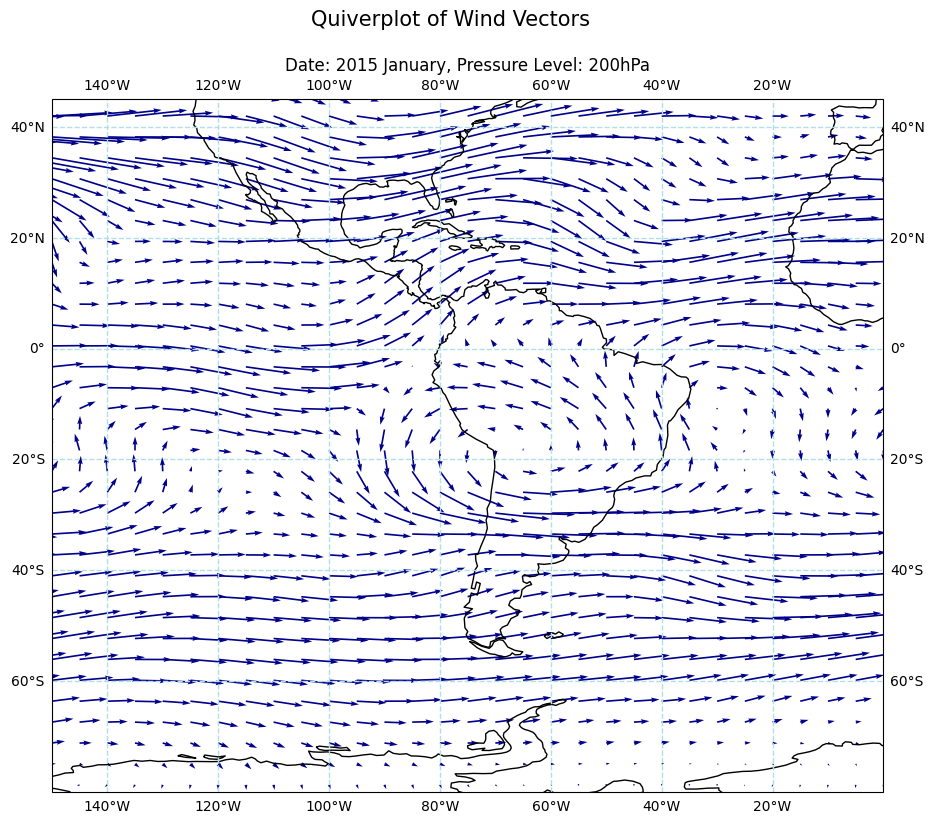

In [6]:
%%time
# location based vector data--> option 1: Quivers

# select and prepare data
u = eastwind[::4, ::4]
v = northwind[::4, ::4]
windspeed = (u**2 + v**2)**0.5

projection = ccrs.PlateCarree(central_longitude=0) # only works with rectangular/square projections

## Plotting
fig = plt.figure(figsize=fig_dimensions)
ax = plt.axes(projection=projection)

# # plain coloured arrows
qv = ax.quiver(u.lon, u.lat, u, v, color='darkblue', scale=600, width=0.002, transform=ccrs.PlateCarree())

# # arrows coloured by strength
# qv = ax.quiver(u.lon, u.lat, u, v, windspeed, cmap=cmap, scale=600, width=0.002, transform=ccrs.PlateCarree())
# # but could also color this by a secondary variable...
# secondvar = ozone[::4, ::4]
# qv = ax.quiver(u.lon, u.lat, u, v, secondvar, cmap=cmap, scale=600, width=0.002, transform=ccrs.PlateCarree())
# colorbar = fig.colorbar(qv, ax=ax, location='bottom')

## details
ax.set_extent([-150,0, -80, 45], crs=transform) #[minlon, maxlon, minlat, maxlat]
ax.gridlines(color='powderblue', linestyle='--', linewidth=1, draw_labels=True)
ax.coastlines(color='k', linewidth=1)

## labels/words
colorbar.set_label(label='windspeed (m/s)', size=10)
fig.suptitle(t='Quiverplot of Wind Vectors', size=15)
ax.set_title(label='Date: %s, Pressure Level: %.fhPa' %(timefmt(timeindex), pressurevalue))

# save figure
fig.savefig('H:\\Summer24-25\\Jupyter\\Plots_download\\vector_quiverplot.png')

CPU times: total: 1min
Wall time: 8.95 s


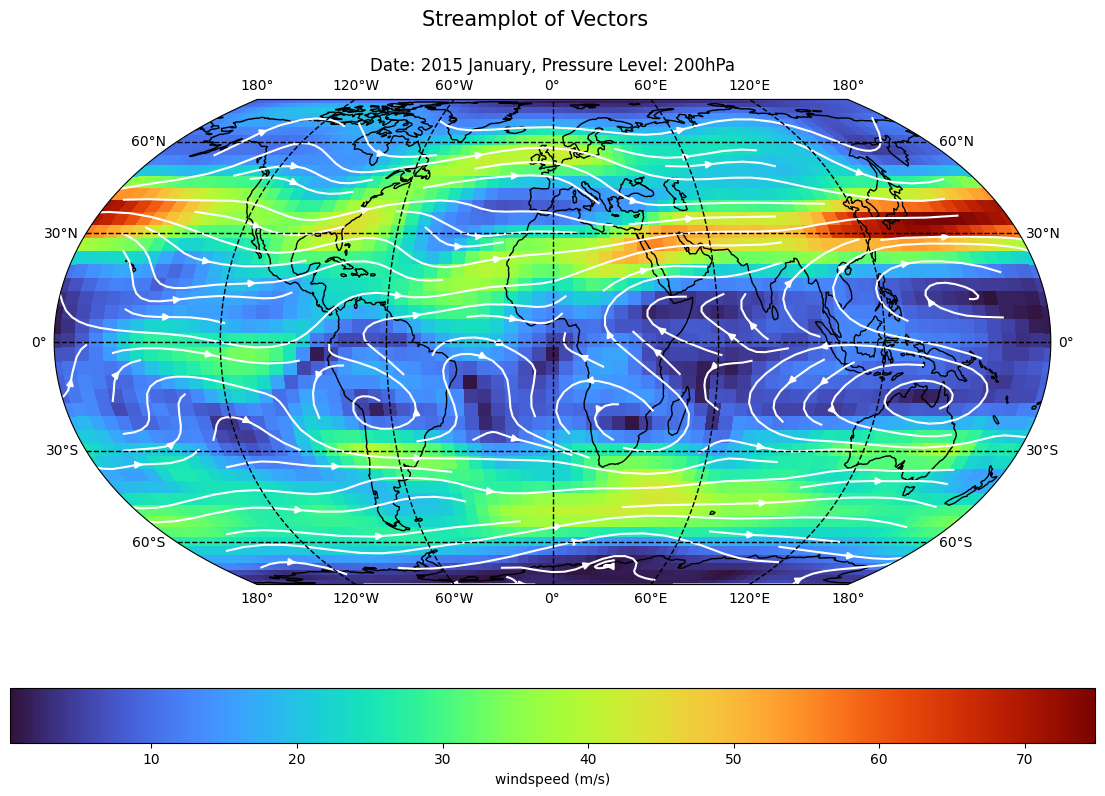

In [7]:
%%time
# location based vector data--> option 2: Streamplot

# select and prepare data
time, plev = 100, 6
u = eastwind[::4, ::4]
v = northwind[::4, ::4]
windspeed = (u**2 + v**2)**0.5
linewidth = 4* (windspeed.values / windspeed.values.max())

projection = ccrs.EqualEarth()
## Plotting
fig = plt.figure(figsize=fig_dimensions)
ax = plt.axes(projection=projection)


strm = ax.streamplot(u.lon, u.lat, u, v, transform=transform, color='w')
bg = windspeed.plot(ax=ax, cmap=cmap, transform=transform, add_colorbar=False)
# options: 
# Plain: streamplot color='k', comment out windspeed.plot and fig.colorbar lines
# Windspeed= Background Colour --> windspeed.plot(...) with streamplot color='w'
# Windspeed= Streamline Colour --> add color=windspeed.values, cmap=cmap to streamplot call, change colorbar call to strm.lines not bg
# Windspeed= Line Width --> add linewidth=lw to streamplot call
# Continuous Lines --> add broken_streamlines=False to streamplot call
# Also, can change density and linewidth in the streamplot call. 
colorbar = fig.colorbar(bg, ax=ax, location='bottom')

## details
ax.gridlines(color='k', linestyle='--', linewidth=1, draw_labels=True)
ax.coastlines(color='k', linewidth=1)

## labels/words
colorbar.set_label(label='windspeed (m/s)', size=10)
fig.suptitle(t='Streamplot of Vectors', size=15)
ax.set_title(label='Date: %s, Pressure Level: %.fhPa' %(timefmt(timeindex), pressurevalue))

# save figure
fig.savefig('H:\\Summer24-25\\Jupyter\\Plots_download\\vector_streamplot.png')

CPU times: total: 19 s
Wall time: 20.1 s


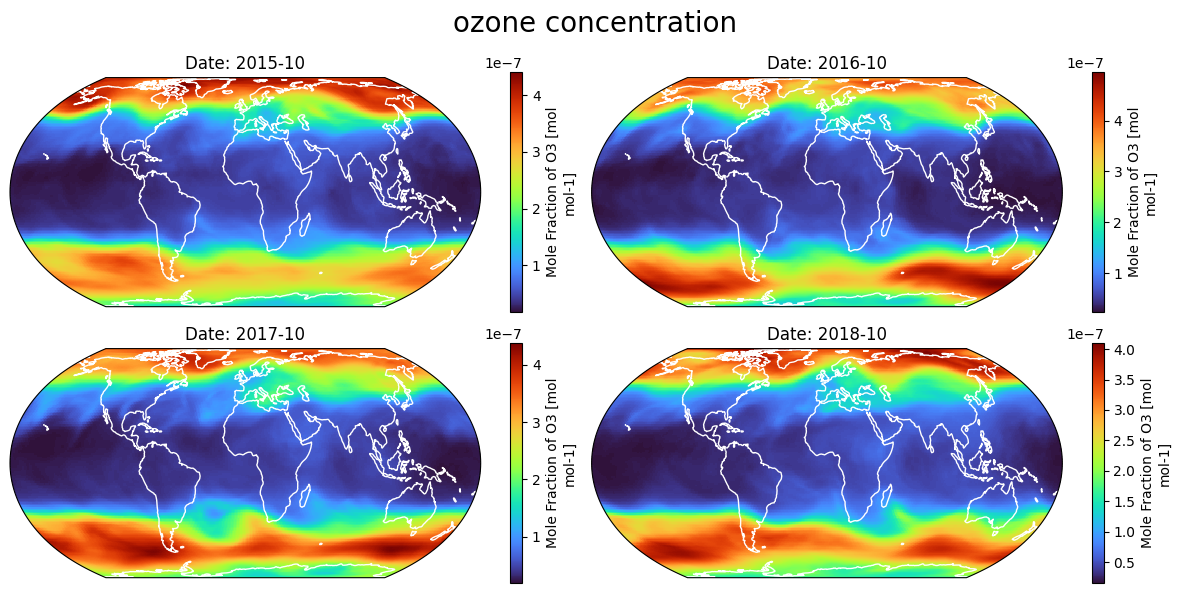

In [8]:
%%time
# Subplots - multiple plots, one figure --> autofit grid to number of times
times = ['2015-10', '2016-10', '2017-10', '2018-10'] # values- use with ds.o3.sel
# times = [9, 21, 33, 45] # indices- use with ds.o3.isel

ds_constants = ds.o3.sel(plev=200) # setting pressure level to 200hPa

row,col = math.ceil(len(times)**0.5), round(len(times)**0.5)
fig, axs = plt.subplots(row,col, figsize=(col*6, row*3), layout='tight', subplot_kw=
                        {'projection': projection})

fig.suptitle('ozone concentration', size=20)
i = 0
for ax in axs.flat:
    if i < len(times):
        # values: 
        ds_constants.sel(time=times[i]).plot(ax=ax, transform=transform, cmap=cmap)
        ax.set_title('Date: %s' %times[i])

        # # indices:
        # ds_constants.isel(time=times[i]).plot(ax=ax, transform=transform, cmap=cmap)
        # ax.set_title('Date: %s' %timefmt(times[i]))

        
        ax.coastlines(color='w')
        i += 1
    else:
        ax.remove()

fig.savefig('vary_subplots_example.png')

## Animated

CPU times: total: 1min 50s
Wall time: 1min 53s


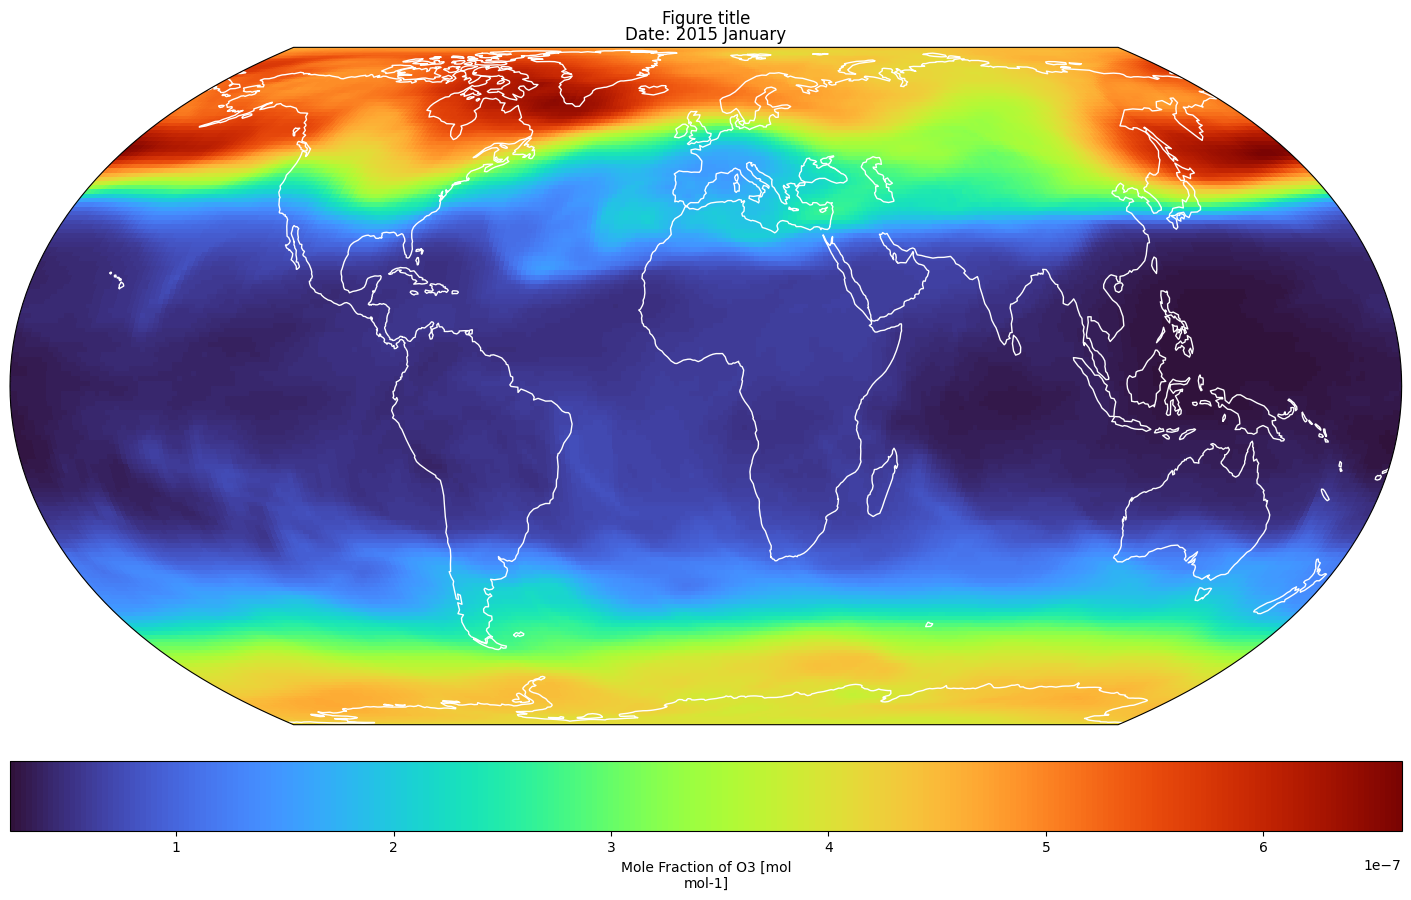

In [9]:
%%time
# animated plots --> animated by timestep -> dataset must have time coordinates

ds_constants = ds.o3.sel(plev=200) # fixing pressure level at 200hPa
num_frames = 25


fig = plt.figure(figsize=fig_dimensions, layout='compressed')
ax=plt.axes(projection=projection)

fig.suptitle('Figure title')
colorbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm_o3, cmap=cmap), ax=ax, location='bottom', label='colorbar')


def animate(num): # function to update each frame

    #unnormalised colours
    fig.clear()
    ax=plt.axes(projection=projection)
    fig.suptitle('Figure title')
    ds_constants.isel(time=num).plot(ax=ax, cmap=cmap, transform=transform, cbar_kwargs={"location": "bottom"})

    # #normalised colours
    # ax.clear() # clear previous plots
    # ds_constants.isel(time=num).plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False, transform=transform)
    
    ax.set_title('Date: %s' %timefmt(num))
    ax.coastlines(color='w')

anim = animation.FuncAnimation(fig, animate, frames=num_frames, interval=200)

anim.save('normnorm.gif', writer='pillow')


## Interactive plots

In [26]:
%matplotlib qt
## Interactive with matplotlib interface, more work but better control

init_plev = pressurevalue
init_time = timeindex
fig = plt.figure()
ax = fig.add_subplot(projection=ccrs.Orthographic(90))
ax.coastlines()
ax.set_global()

graph = ds.o3.isel(time=init_time).sel(plev=init_plev).plot.pcolormesh(ax=ax, transform=transform, cmap=cmap)
ax.set_title('Date: %s' %timefmt(init_time))
fig.subplots_adjust(left=0.25, bottom=0.25)

# horizontal slider --> time
axtime = fig.add_axes([0.25, 0.1, 0.65, 0.03])
time_slider = Slider(ax=axtime, label='Time (Month)', valmin=0, valmax=24, valstep=1, valinit=init_time,)

# vertical slider -> plev
axplev = fig.add_axes([0.1, 0.25, 0.0225, 0.63])
plev_slider = Slider(ax=axplev, label='Pressure Level (hPa)', valmin=70, valmax=400, 
                     valstep=ds.plev, valinit=init_plev, orientation="vertical",)

def update(val):
    graph.set_array(ds.o3.isel(time=time_slider.val).sel(plev=plev_slider.val))
    ax.set_title('Date: %s' %timefmt(time_slider.val))
    # fig.canvas.draw_idle()

# register the update function with each slider
time_slider.on_changed(update)
plev_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')


def reset(event):
    time_slider.reset()
    plev_slider.reset()
    
button.on_clicked(reset)

plt.show()

In [42]:
import holoviews as hv
import hvplot.xarray
## Interactive with holoview interface, less work but slower and less control
hv.output(widget_location='bottom')
data = ds.o3.isel(time=slice(0,24,1), plev=slice(7,11))
data.hvplot(
    'lon', 'lat', projection=ccrs.Orthographic(90), global_extent=True, project=True, 
    cmap='turbo', coastline=True, size=500, clim=(10**-8, 5*10**-7)
)

:DynamicMap   [time,plev]
   :Overlay
      .Image.I     :Image   [lon,lat]   (Mole Fraction of O3)
      .Coastline.I :Feature   [Longitude,Latitude]

In [41]:
from holoviews import opts
from holoviews import streams
path = hv.Path([])
freehand = streams.FreehandDraw(source=path, num_objects=6, styles={'line_color':'yellow'})
path.opts(opts.Path(active_tools=['freehand_draw'], height=500, line_width=20, width=1000))
path
# hvplot.show(path)

:Path   [x,y]